In [1]:
import gym
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

warnings.filterwarnings("ignore")

In [2]:
class Monte_Calro_Method:
    def __init__(self, bin_list, num_episodes, gamma, epsilon, max_steps):
        self.bin_list = bin_list
        self.num_episodes = num_episodes
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_steps = max_steps

    def discretize(self, obs):
        idxs = [
            min(max(np.digitize(o, b) - 1, 0), len(b) - 1)
            for o, b in zip(obs, self.bin_list)
        ]
        return tuple(idxs)

    def decay_epsilon(self, rewards_log):
        avg_reward = np.mean(rewards_log[-10:])
        if avg_reward > 400:
            self.epsilon = 0.0001

    def fit(self, env, Q, count):
        rewards_log = []
        for _ in tqdm(range(self.num_episodes)):
            # (a) 에피소드 생성
            obs, info = env.reset()
            states, actions, rewards = [], [], []

            for _step in range(self.max_steps):
                s = self.discretize(obs)
                # ε-탐욕
                if random.random() < self.epsilon:
                    a = random.randint(0, 1)
                else:
                    a = np.argmax(Q[s])

                obs_next, r, done, truncated, info = env.step(a)

                states.append(s)
                actions.append(a)
                rewards.append(r)

                obs = obs_next

            # (b) 에피소드별 총 보상
            ep_reward = np.sum(rewards)
            rewards_log.append(ep_reward)
            self.decay_epsilon(rewards_log)

            # (c) 역방향 누적합으로 G 계산
            #  예: G[t] = r[t] + gamma*r[t+1] + ... (역순으로 누적)
            # vector화: reversed cumsum
            #   r = [r0, r1, ..., rT-1],  G[T-1] = r[T-1], G[t] = r[t] + gamma*G[t+1]
            R = np.array(rewards, dtype=np.float32)
            T = len(R)
            G = np.zeros(T, dtype=np.float32)
            G[-1] = R[-1]
            for i in range(T - 2, -1, -1):
                G[i] = R[i] + self.gamma * G[i + 1]

            # (d) Q[s][a]를 “점진적 평균”으로 업데이트
            #     count[s][a] += 1
            #     Q[s][a] <- Q[s][a] + (G - Q[s][a]) / count[s][a]
            #   한 에피소드에서 같은 (s,a)가 여러 번 나올 수 있으니, 모두 처리
            #   (Every-Visit MC)
            #   벡터화(ish) 처리: 그래도 (s,a)별 딕셔너리 접근은 loop 필요
            for i in range(T):
                s_i, a_i = states[i], actions[i]
                g_i = G[i]
                count[s_i][a_i] += 1
                c = count[s_i][a_i]
                # Q <- Q + (g - Q)/c
                Q[s_i][a_i] += (g_i - Q[s_i][a_i]) / c

        env.close()
        return Q, rewards_log

In [3]:
# 1) 환경 & 이산화 준비
env = gym.make('CartPole-v1')
num_bins = 12
# 관측 범위
ranges = [(-4.8, 4.8), (-3, 3), (-0.418, 0.418), (-4, 4)]
bins_list = [np.linspace(lo, hi, num_bins) for (lo, hi) in ranges]

# 2) Q, 카운트(점진적 평균)
Q = defaultdict(lambda: np.random.uniform(low=0, high=10, size=(env.action_space.n)).astype(np.float32))
count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=np.int32))

In [4]:
MC = Monte_Calro_Method(bins_list, num_episodes=2500, gamma=0.99, epsilon=0.2, max_steps=500)
Q, rewards = MC.fit(env, Q, count)

100%|██████████| 2500/2500 [01:05<00:00, 38.15it/s]


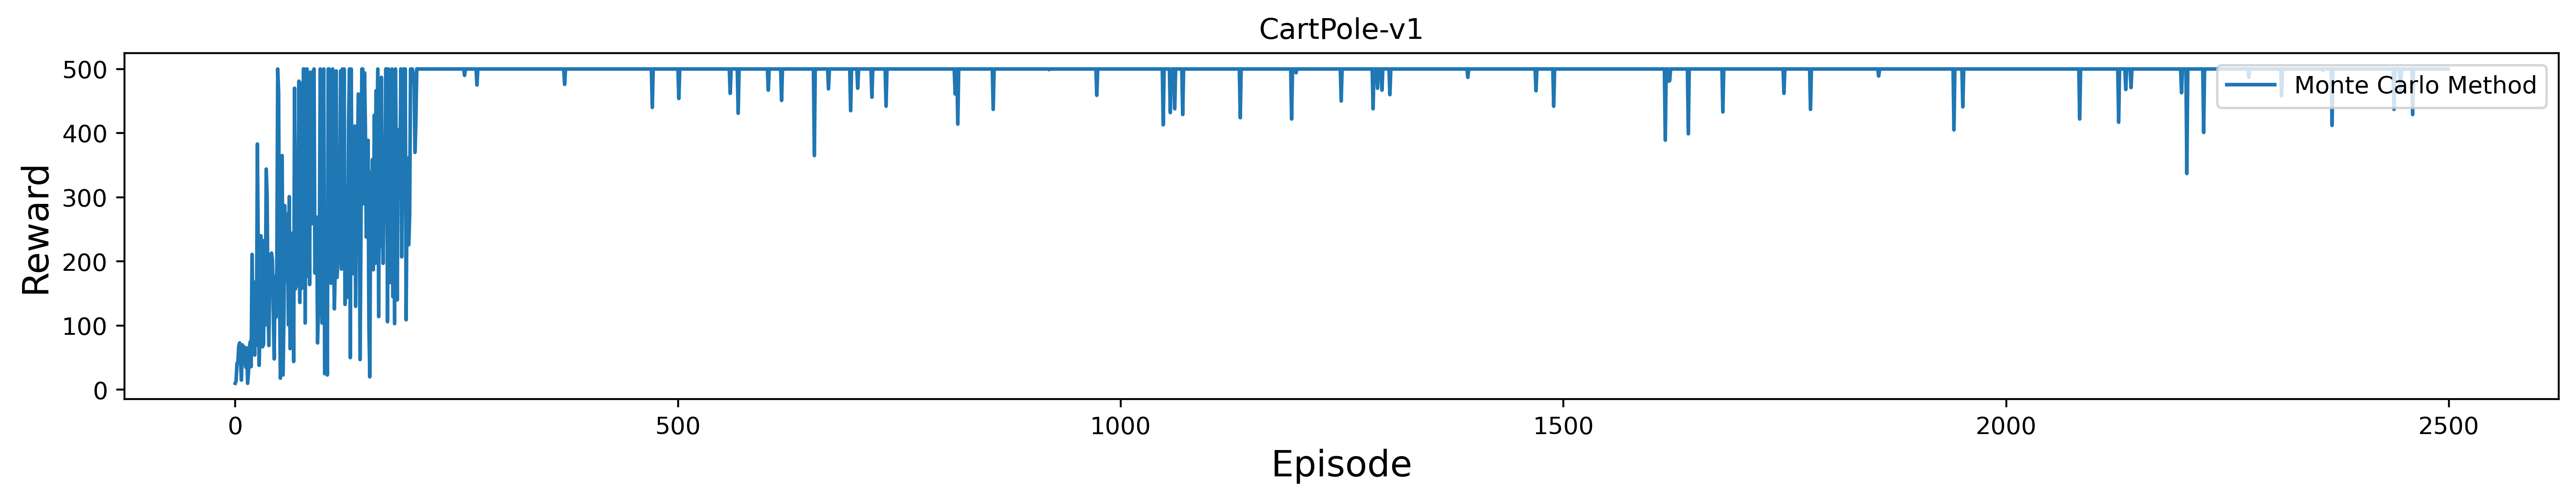

최종 epsilon: 0.0001
초반 10개 에피소드 보상: [10.0, 14.0, 41.0, 43.0, 68.0, 73.0, 44.0, 15.0, 70.0, 49.0]
마지막 10개 에피소드 보상: [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
최근 100 에피소드 평균 보상: 498.21


In [5]:
plt.figure(figsize=(15, 3), dpi=400)
plt.plot(np.array(rewards), label="Monte Carlo Method")
plt.title('CartPole-v1')
plt.xlabel('Episode', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"최종 epsilon: {MC.epsilon}")
print("초반 10개 에피소드 보상:", rewards[:10])
print("마지막 10개 에피소드 보상:", rewards[-10:])
avg_reward_recent = np.mean(rewards[-100:])
print(f"최근 100 에피소드 평균 보상: {avg_reward_recent:.2f}")